In [1]:
%load_ext autoreload
%autoreload 2


import utils

import pandas as pd
import numpy as np
from tqdm import tqdm
import codecs

## Look at some files

In [2]:
def get_random_row(df):
    return df.iloc[[np.random.choice(len(df))]]

def print_random_code(df):
    random_row = get_random_row(df)
    random_file_path = list(random_row['directory'])[0].replace("\\","/")
    with codecs.open(random_file_path,encoding='utf-8', errors='replace', mode = 'r') as f:
        data = f.read()
    print(random_file_path)
print(data)

In [50]:
files_index = pd.read_csv("data/search_repo_indices/files_index.csv",index_col=0)

In [ ]:
print_random_code(files_index)

In [26]:
matches = utils.get_multi_line_comments(data)
utils.process_found_comments(matches)

''

In [28]:
matches = utils.get_single_line_comments(data)
utils.process_found_comments(matches)

'SPDX-FileCopyrightText: 2020 Efabless Corporation Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http:www.apache.orglicensesLICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. SPDX-License-Identifier: Apache-2.0 Tunable ring oscillator---synthesizable (physical) version. NOTE: This netlist cannot be simulated correctly due to lack of accurate timing in the digital cell verilog models. Ring oscillator with 13 stages, each with two trim bits delay (see above). Trim is not binary: For trim[1:0], lower bit trim[0] is primary trim and must be applied first; upper bit trim[1] is secondary trim and should only 

## Analyse reading errors
NaN values in 'code' column means that the file was empty (empty string in csv is read in as nan). Replace them with empty string after reading from csv!

In [82]:
partition_index = 5
df = pd.read_csv(f"data/verilog_partitions/files_index_part_{partition_index}.csv",index_col=0)

In [83]:
print(len(df))
print(len(df.dropna()))
new_df = df.fillna("")
print(len(new_df.dropna()))

31468
31428
31468


In [84]:
new_df[new_df['code'].str.startswith("0:FOUND ERROR")]

,directory,repo_id,file_name,extension,code


## Analyse source code lengths 

In [3]:
def get_code_lines(df):
    # https://stackoverflow.com/questions/16236684/apply-pandas-function-to-column-to-create-multiple-new-columns/47097625#47097625
    no_lines, max_line_length = [], []
    for c in tqdm(df['code']):
        c = str(c)
        lines = c.split("\n")
        no_lines.append(len(lines))
        max_line_length.append(max(map(len,lines)))
    df['no_lines'] = no_lines
    df['max_line_len'] = max_line_length
    return df

In [93]:
number_of_partitions = 10
for i in range(number_of_partitions):
    df_dir = f"data/verilog_partitions/files_index_part_{i}.csv"
    print(f"Starting {i}")
    partition_df = utils.read_csv(df_dir)
    new_partition_df = get_code_lines(partition_df)
    new_partition_df.to_csv(df_dir)
    del partition_df, new_partition_df
print("All done!")

# TIME BOTTLENECK HERE IS READING/WRITING CSV!

Starting 0


100%|██████████| 31468/31468 [00:04<00:00, 7123.76it/s] 


Starting 1


100%|██████████| 31468/31468 [00:03<00:00, 9304.52it/s] 


Starting 2


100%|██████████| 31468/31468 [00:03<00:00, 9449.21it/s] 


Starting 3


100%|██████████| 31467/31467 [00:08<00:00, 3755.47it/s]


Starting 4


100%|██████████| 31468/31468 [00:17<00:00, 1775.64it/s]


Starting 5


100%|██████████| 31468/31468 [00:08<00:00, 3864.55it/s] 


Starting 6


100%|██████████| 31467/31467 [00:09<00:00, 3232.69it/s]


Starting 7


100%|██████████| 31468/31468 [00:19<00:00, 1639.79it/s]


Starting 8


100%|██████████| 31468/31468 [00:19<00:00, 1626.78it/s]


Starting 9


100%|██████████| 31468/31468 [00:03<00:00, 9167.98it/s] 


All done!


In [95]:
number_of_partitions = 10
for i in range(number_of_partitions):
    df_dir = f"data/verilog_partitions/files_index_part_{i}.csv"
    print(f"Reading {i}")
    partition_df = utils.read_csv(df_dir)
    combined_df = pd.concat([combined_df, partition_df.drop(['code'],axis=1)])
    del partition_df
print("All done!")

Reading 0
Reading 1
Reading 2
Reading 3
Reading 4
Reading 5
Reading 6
Reading 7
Reading 8
Reading 9
All done!


In [96]:
combined_df.to_csv("data/verilog_partitions/file_index_with_code_lengths.csv")

In [97]:
combined_df = utils.read_csv("data/verilog_partitions/file_index_with_code_lengths.csv")

/mnt/c/Users/dehaer34/Documents/GitHub/hdl_dataset_creation/utils.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path,index_col=0).fillna("")


In [98]:
print(combined_df['no_lines'].median())
print(combined_df['no_lines'].mean())
print(combined_df['no_lines'].min())
print(combined_df['no_lines'].max())

112.0
2484.6125229453946
1
4643536


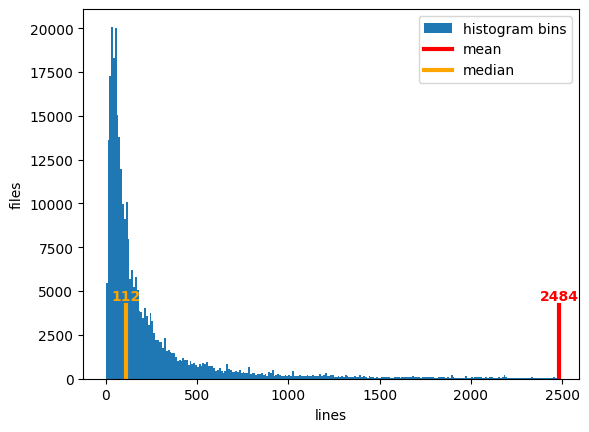

In [104]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
bins=list(range(0,2472,10))
ax.hist(combined_df['no_lines'],bins=bins,density=False, histtype='bar',label='histogram bins')
ax.axvline(x=combined_df['no_lines'].mean(),ymin=0,ymax=0.2,color='red',linewidth=3.0,label='mean')
ax.axvline(x=combined_df['no_lines'].median(),ymin=0,ymax=0.2,color='orange',linewidth=3.0,label='median')
ax.set_xticks(list(range(0,2501,500)))
ax.set_xlabel('lines')
ax.set_ylabel('files')
ax.text(combined_df['no_lines'].median(),4500,str(int(combined_df['no_lines'].median())),color='orange',ha='center',weight='heavy')
ax.text(combined_df['no_lines'].mean(),4500,str(int(combined_df['no_lines'].mean())),color='red',ha='center',weight='heavy')
ax.legend()
fig.savefig("number_of_lines.png",dpi=1200)

(array([   0.,  873.,  452.,  324.,  377.,  364.,  756.,  629.,  850.,
         824.,  972., 1360., 1576., 1332., 1150., 1420., 1221., 1359.,
        1478., 1727., 1523., 1860., 2019., 1765., 1498., 1605., 1696.,
        1516., 2086., 1689., 1797., 1637., 1695., 1603., 2740., 1779.,
        2563., 1553., 2962., 1751., 2279., 1544., 1781., 2078., 2515.,
        1680., 1478., 1599., 3351.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]),
 <BarContainer object of 49 artists>)

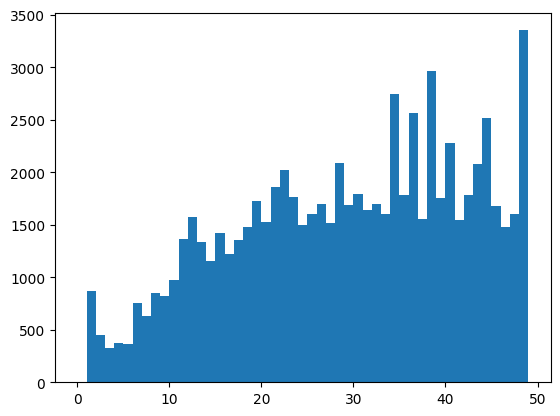

In [100]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
bins=list(range(0,50,1))
ax.hist(combined_df['no_lines'],bins=bins,density=False, histtype='bar',label='histogram bins')

In [101]:
print(combined_df['max_line_len'].median())
print(combined_df['max_line_len'].mean())
print(combined_df['max_line_len'].min())
print(combined_df['max_line_len'].max())

87.0
531.1254041247721
0
2003588


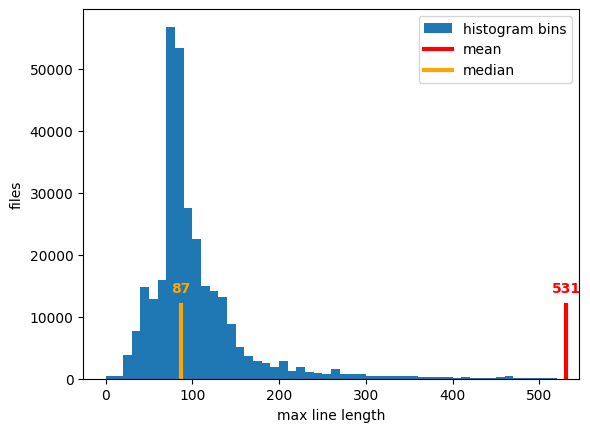

In [105]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
bins=list(range(0,522,10))
ax.hist(combined_df['max_line_len'],bins=bins,density=False, histtype='bar',label='histogram bins')
ax.axvline(x=combined_df['max_line_len'].mean(),ymin=0,ymax=0.2,color='red',linewidth=3.0,label='mean')
ax.axvline(x=combined_df['max_line_len'].median(),ymin=0,ymax=0.2,color='orange',linewidth=3.0,label='median')
ax.set_xticks([0,100,200,300,400,500])
# ax.set_xticklabels(['0','\n86','100','200','300','400','500','\n522'])
ax.set_xlabel('max line length')
ax.set_ylabel('files')
ax.text(combined_df['max_line_len'].median(),14000,str(int(combined_df['max_line_len'].median())),color='orange',ha='center',weight='heavy')
ax.text(combined_df['max_line_len'].mean(),14000,str(int(combined_df['max_line_len'].mean())),color='red',ha='center',weight='heavy')
ax.legend()
fig.savefig("max_line_length.png",dpi=1200)

(array([3.630e+02, 8.100e+01, 8.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.100e+01, 4.000e+00, 1.000e+00, 5.000e+00, 8.000e+00, 1.100e+01,
        1.800e+01, 2.200e+01, 2.600e+01, 2.400e+01, 3.200e+01, 4.700e+01,
        9.500e+01, 1.250e+02, 1.600e+02, 2.620e+02, 3.760e+02, 3.280e+02,
        2.880e+02, 4.120e+02, 3.750e+02, 5.110e+02, 5.690e+02, 5.800e+02,
        5.600e+02, 7.200e+02, 7.470e+02, 7.570e+02, 7.840e+02, 7.120e+02,
        7.960e+02, 8.460e+02, 1.768e+03]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39.]),
 <BarContainer object of 39 artists>)

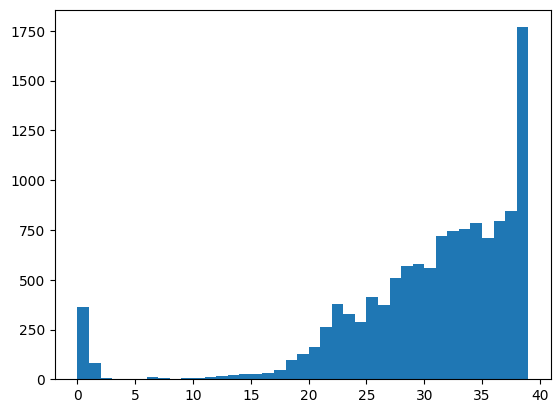

In [106]:
fig,ax = plt.subplots()
bins=list(range(0,40,1))
ax.hist(combined_df['max_line_len'],bins=bins,density=False, histtype='bar',label='histogram bins')

## Analyse comments

In [4]:
from tqdm import tqdm 
import pandas as pd
tqdm.pandas(desc='Applying')

In [5]:
def get_all_comments_from_code(source_code):
    multi_line_matches = utils.get_multi_line_comments(source_code)
    multi_line_comments = utils.process_found_comments(multi_line_matches)
    single_line_matches = utils.get_single_line_comments(source_code)
    single_line_comments = utils.process_found_comments(single_line_matches)
    return multi_line_comments.lower(), single_line_comments.lower()

def search_keywords_in_comments(comments, keywords):
    keywords_found = []
    for kw in keywords:
        if kw in comments:
            keywords_found.append(kw)
    return keywords_found

def search_keywords_in_row(row, keywords):
    mlc,slc = get_all_comments_from_code(row['code'])
    keywords_found_slc = search_keywords_in_comments(slc,keywords)
    keywords_found_mlc = search_keywords_in_comments(mlc,list(set(keywords_found_slc) - set(keywords)))
    return list(set(keywords_found_slc + keywords_found_mlc))

In [7]:
generation_keywords = list(map(lambda x: x.lower(), ["generated using", "auto-generated", "autogenerated", "generated by", "Cadence Genus", "WIZARD-GENERATED", "Yosys", "Vivado(TM) HLS - High-Level Synthesis","generated_end (DO NOT EDIT ABOVE)", "generated_beg (DO NOT EDIT BELOW)","AUTOMATICALLY GENERATED", "CORE_GENERATION_INFO"]))
license_whitelist_keywords = list(map(lambda x: x.lower(), ["Apache License", "General Public License", "GPL license", "MIT License", "freely distributable", "Open Source Project", "Open Hardware License", "Solderpad Hardware License", "netfpga", "Free Software Foundation", "Redistribution and use in source and binary forms, with or without modification, are permitted"]))
license_blacklist_keywords = list(map(lambda x: x.lower(), ["confidential", "proprietary", "all right reserved", "all rights reserved", "Non-Disclosure Agreement (NDA)"]))

In [13]:
number_of_partitions = 10
for i in range(number_of_partitions):
    df_dir = f"data/verilog_partitions/files_index_part_{i}.csv"
    print(f"Starting {i}")
    partition_df = utils.read_csv(df_dir)
    partition_df['generation_keywords'] = partition_df.progress_apply(lambda row: search_keywords_in_row(row,generation_keywords),axis=1)
    partition_df['license_whitelist_keywords'] = partition_df.progress_apply(lambda row: search_keywords_in_row(row,license_whitelist_keywords),axis=1)
    partition_df['license_blacklist_keywords'] = partition_df.progress_apply(lambda row: search_keywords_in_row(row,license_blacklist_keywords),axis=1)
    partition_df.to_csv(df_dir)
    del partition_df
print("All done!")

Starting 0


Applying: 100%|██████████| 31468/31468 [01:54<00:00, 275.39it/s] 


Starting 1


Applying: 100%|██████████| 31468/31468 [01:36<00:00, 324.52it/s] 


Starting 2


Applying: 100%|██████████| 31468/31468 [36:17<00:00, 14.45it/s]   


Starting 3


Applying: 100%|██████████| 31467/31467 [03:23<00:00, 154.99it/s] 


Starting 4


Applying: 100%|██████████| 31468/31468 [05:20<00:00, 98.21it/s]  


Starting 5


Applying: 100%|██████████| 31468/31468 [03:36<00:00, 145.23it/s] 


Starting 6


Applying: 100%|██████████| 31467/31467 [06:35<00:00, 79.59it/s]  


Starting 7


Applying: 100%|██████████| 31468/31468 [08:35<00:00, 61.00it/s]  


Starting 8


Applying: 100%|██████████| 31468/31468 [08:39<00:00, 60.54it/s]  


Starting 9


Applying: 100%|██████████| 31468/31468 [02:36<00:00, 200.92it/s] 


All done!


In [15]:
number_of_partitions = 10
for i in range(number_of_partitions):
    df_dir = f"data/verilog_partitions/files_index_part_{i}.csv"
    print(f"Reading {i}")
    partition_df = utils.read_csv(df_dir)
    combined_df = pd.concat([combined_df, partition_df.drop(['code'],axis=1)])
    del partition_df
print("All done!")

Reading 0
Reading 1
Reading 2
Reading 3
Reading 4
Reading 5
Reading 6
Reading 7
Reading 8
Reading 9
All done!


In [16]:
combined_df.to_csv("data/verilog_partitions/file_index_with_code_lengths_and_keywords.csv")

## Filtering

In [24]:
import matplotlib.pyplot as plt

In [2]:
combined_df = utils.read_csv("data/verilog_partitions/file_index_with_code_lengths_and_keywords.csv")

/mnt/c/Users/dehaer34/Documents/GitHub/hdl_dataset_creation/utils.py:21: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,index_col=0)


In [4]:
has_autogen_kw = combined_df[combined_df.apply(lambda row: utils.list_is_not_empty(row, 'generation_keywords'), axis=1)]
print(len(has_autogen_kw))

19584


In [31]:
print(has_autogen_kw['no_lines'].median())
print(has_autogen_kw['no_lines'].mean())
print(has_autogen_kw['no_lines'].min())
print(has_autogen_kw['no_lines'].max())
print(has_autogen_kw['no_lines'].std())

255.0
3251.063214869281
6
1518493
28736.95132576627


In [29]:
print(has_autogen_kw['max_line_len'].median())
print(has_autogen_kw['max_line_len'].mean())
print(has_autogen_kw['max_line_len'].min())
print(has_autogen_kw['max_line_len'].max())

99.0
1237.992902369281
37
1989025


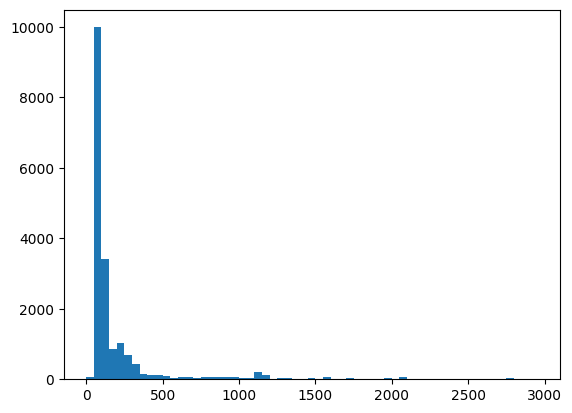

In [30]:
fig,ax = plt.subplots()
bins=list(range(0,3000,50))
ax.hist(has_autogen_kw['max_line_len'],bins=bins, density=False, histtype='bar',label='histogram bins')
fig.show()

In [160]:
print(combined_df['no_lines'].median())
print(combined_df['no_lines'].mean())
print(combined_df['no_lines'].min())
print(combined_df['no_lines'].max())
print(combined_df['no_lines'].std())

112.0
2484.6125229453946
1
4643536
44073.648290924255


In [33]:
cutoff_no_lines = combined_df[combined_df['no_lines'] < 2484]
print(len(combined_df))
print(len(cutoff_no_lines))

314878
300893


In [41]:
len(combined_df[combined_df.apply(lambda x: utils.list_is_not_empty(x, 'license_blacklist_keywords'), axis=1)])

52757

In [42]:
license_filtered_df = utils.filter_df_by_license_keywords(combined_df)
print(len(license_filtered_df))

267446


In [45]:
license_autogen_filtered_df = license_filtered_df[np.logical_not(license_filtered_df.apply(lambda row: utils.list_is_not_empty(row,'generation_keywords'), axis=1))]
print(len(license_autogen_filtered_df))

254155


In [ ]:
license_autogen_filtered_df

In [46]:
print(license_autogen_filtered_df['no_lines'].median())
print(license_autogen_filtered_df['no_lines'].mean())
print(license_autogen_filtered_df['no_lines'].min())
print(license_autogen_filtered_df['no_lines'].max())
print(license_autogen_filtered_df['no_lines'].std())

95.0
2657.0283999921307
1
4643536
48136.45629681829


In [165]:
lic_ag_minnol_filtered_df = license_autogen_filtered_df[license_autogen_filtered_df['no_lines'] >= 5]
print(len(lic_ag_minnol_filtered_df))

252129


In [219]:
lic_ag_minnol_minml_filtered_df = lic_ag_minnol_filtered_df[lic_ag_minnol_filtered_df['max_line_len'] >= 15]
print(len(lic_ag_minnol_minml_filtered_df))

252100


In [221]:
print(lic_ag_minnol_minml_filtered_df['no_lines'].median())
print(lic_ag_minnol_minml_filtered_df['no_lines'].mean())
print(lic_ag_minnol_minml_filtered_df['no_lines'].min())
print(lic_ag_minnol_minml_filtered_df['no_lines'].max())
print(lic_ag_minnol_minml_filtered_df['no_lines'].std())

96.0
2678.590928203094
5
4643536
48331.645325632555


In [234]:
lic_ag_minnol_minml_maxnol_filtered_df = lic_ag_minnol_minml_filtered_df[lic_ag_minnol_minml_filtered_df['no_lines'] <= 1500]
print(len(lic_ag_minnol_minml_maxnol_filtered_df))

237415


In [241]:
# Same max line length limit as codex paper!
lic_ag_minnol_minml_maxnol_maxml_filtered_df = lic_ag_minnol_minml_maxnol_filtered_df[lic_ag_minnol_minml_maxnol_filtered_df['max_line_len'] <= 1000]
print(len(lic_ag_minnol_minml_maxnol_maxml_filtered_df))

234624


In [244]:
lic_ag_minnol_minml_maxnol_maxml_filtered_df.to_csv("data/search_repo_indices/first_filter_index.csv")

In [266]:
combined_df.index = combined_df.index.astype(str)

In [274]:
print(len(combined_df))
# indices_to_drop=combined_df.drop([14295,71423,133481,206779,24111],axis=0)
indices_to_drop_df = combined_df.drop(list(lic_ag_minnol_minml_maxnol_maxml_filtered_df.index.astype(str)))
print(len(lic_ag_minnol_minml_maxnol_maxml_filtered_df))
print(len(indices_to_drop_df))

314878
234624
80254


In [277]:
indices_to_keep = set(list(lic_ag_minnol_minml_maxnol_maxml_filtered_df.index.astype(str)))

In [291]:
number_of_partitions = 10
for i in range(number_of_partitions):
    df_dir = f"data/verilog_partitions/files_index_part_{i}.csv"
    out_dir = f"data/verilog_partitions/filtered_files_index_part_{i}.csv"
    print(f"Starting {i}")
    partition_df = utils.read_csv(df_dir)
    new_partition_df = partition_df[partition_df.index.astype(str).isin(indices_to_keep)]
    new_partition_df_only_code = new_partition_df.drop(columns=['no_lines','max_line_len','generation_keywords','license_whitelist_keywords','license_blacklist_keywords'])
    new_partition_df_only_code.to_csv(out_dir)
    print(f"Length after filtering: {len(new_partition_df)}")
    del partition_df, new_partition_df
print("All done!")

Starting 0
Length after filtering: 21276
Starting 1
Length after filtering: 21891
Starting 2
Length after filtering: 23935
Starting 3
Length after filtering: 23049
Starting 4
Length after filtering: 28330
Starting 5
Length after filtering: 24888
Starting 6
Length after filtering: 22118
Starting 7
Length after filtering: 23986
Starting 8
Length after filtering: 26359
Starting 9
Length after filtering: 18638
All done!


In [298]:
number_of_partitions = 10
for i in range(number_of_partitions):
    df_dir = f"data/verilog_partitions/filtered_files_index_part_{i}.csv"
    print(f"Starting {i}")
    partition_df = utils.read_csv(df_dir)
    combined_filtered_df = pd.concat([combined_filtered_df, partition_df])
    del partition_df
print("All done!")

Starting 0
Starting 1
Starting 2
Starting 3
Starting 4
Starting 5
Starting 6
Starting 7
Starting 8
Starting 9
All done!


In [ ]:
combined_filtered_df.to_csv(f"data/verilog_partitions/filtered_files_code.csv")

In [300]:
print(len(combined_filtered_df))

234624


In [302]:
combined_filtered_deduplicated_df = combined_filtered_df.drop_duplicates(subset=['code'])

In [303]:
combined_filtered_deduplicated_df.to_csv(f"data/verilog_partitions/filtered_exact_deduplicated_files_code.csv")

In [304]:
print(len(combined_filtered_deduplicated_df))

151204


In [3]:
combined_df = utils.read_csv("data/verilog_partitions/file_index_with_code_lengths_and_keywords.csv")
combined_filtered_deduplicated_df = utils.read_csv(f"data/verilog_partitions/filtered_exact_deduplicated_files_code.csv")

/mnt/c/Users/dehaer34/Documents/GitHub/hdl_dataset_creation/utils.py:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path,index_col=0).fillna("")


In [10]:
filtered_deduplicated_indices = set(list(combined_filtered_deduplicated_df.index.astype(str)))
filtered_deduplicated_index_df = combined_df[combined_df.index.astype(str).isin(filtered_deduplicated_indices)]

In [12]:
filtered_deduplicated_index_df.to_csv("data/verilog_partitions/filtered_deduplicated_file_index.csv")

## Near-deduplication filtering

In [1]:
import json

In [2]:
clones = json.load(open("logs/not_subtokens.json",'r'))
len(clones)

17741

In [3]:
total_no_files = 0
for l in clones:
    total_no_files += len(l)
total_no_files

68339

In [11]:
keep_lookup_table = utils.create_near_clone_filter_lookup_table(clones)

In [ ]:
index_df = utils.read_csv("data/icarus_partitions/icarus_processed_full.csv")

In [17]:
near_deduplicated_index = index_df[index_df.apply(lambda row: utils.keep_file(row['directory'],keep_lookup_table),axis=1)]

In [19]:
near_deduplicated_index.to_csv("data/search_repo_indices/filtered_near_deduplicated_file_index.csv")

In [21]:
near_deduplicated_index = utils.read_csv("data/search_repo_indices/filtered_near_deduplicated_file_index.csv")
code_df = utils.read_csv("data/verilog_partitions/filtered_exact_deduplicated_files_code.csv")

In [22]:
near_dedup_code_df = code_df.loc[near_deduplicated_index.index]

In [24]:
near_dedup_code_df.to_csv("data/verilog_partitions/filtered_near_deduplicated_files_code.csv")